# Analysis of effect of climatology on ENSO predictability analysis
## Fist checking whether I can reproduce the results of Delsole and Tippett

In [1]:
%cd /OSM/CBR/OA_DCFP/work/squ027/doppyo/
! python setup.py install >/dev/null

/OSM/CBR/OA_DCFP/work/squ027/doppyo
zip_safe flag not set; analyzing archive contents...


In [2]:
import doppyo
import importlib
doppyo = importlib.reload(doppyo)

In [3]:
import re
import os
import glob
import random
import itertools
import numpy as np
import pandas as pd
import xarray as xr

import cartopy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# Notebook specific -----
%matplotlib inline

In [4]:
import dask
import distributed
client = distributed.Client('tcp://oa-32-cdc.nexus.csiro.au:8786')
client

Client Scheduler: tcp://oa-32-cdc.nexus.csiro.au:8786 Dashboard: http://oa-32-cdc.nexus.csiro.au:8787/status,Cluster Workers: 16 Cores: 128 Memory: 1024.00 GB


In [5]:
saveloc = '/OSM/CBR/OA_DCFP/work/squ027/squire_scratch/projects/papers/Risbey_Nature/'

# Load the raw temperature data, compute anomalies and nino3.4

In [6]:
lambda_anomalize = lambda data, clim: doppyo.utils.datetime_to_leadtime(
                                          doppyo.utils.anomalize(
                                              doppyo.utils.leadtime_to_datetime(data), clim))

In [7]:
def natural_keys(path):
    basename = os.path.basename(path)
    return [ int(c) for c in re.split('(\d+)', basename) if c.isdigit()]

In [8]:
def init_date_to_target_date(da, init_date_coord='month', lead_time_coord='lead_time'):
    """ 
        Convert from initial date format to target date format 
        Note : this function only works when initial date and lead time are matching frequencies
    """
    new = []
    for lead in da[lead_time_coord]:
        rolled = da.sel({lead_time_coord : lead.values}).roll(**{init_date_coord : lead.values})
        rolled[init_date_coord].values = da[init_date_coord].values
        new.append(rolled)

    return xr.concat(new, dim=lead_time_coord).rename({init_date_coord : init_date_coord.replace('init','target')})

### Raw NOAA OISST data (downloaded from http://www.cpc.ncep.noaa.gov/data/indices/sstoi.indices.)

In [9]:
time = pd.date_range(start='1982-01',end='2019-02',freq='MS')
data = np.array([26.72,26.7,27.2,28.02,28.54,28.75,28.1,27.93,28.11,28.64,28.81,29.21,29.36,29.13,29.03,28.91,28.89,28.24,27.07,26.53,26.44,25.87,25.58,25.59,25.64,26.39,26.86,27.39,27.39,26.86,26.74,26.34,26.43,25.93,25.41,25,25.43,25.67,26.23,26.8,27.11,26.86,26.69,26.5,26.25,26.19,26.19,26.11,25.79,25.94,26.65,27.44,27.5,27.69,27.37,27.15,27.33,27.57,27.73,27.7,27.91,28.02,28.47,28.8,28.75,29.03,28.8,28.58,28.39,28.07,27.99,27.6,27.32,27.22,27.31,27.32,26.48,26.11,25.57,25.24,25.43,24.62,24.27,24.33,24.53,25.33,25.9,26.69,27.09,26.98,26.74,26.33,26.25,26.26,26.24,26.38,26.55,26.95,27.46,28.02,28.06,27.58,27.25,27.05,26.75,26.98,26.72,26.91,27.01,26.93,27.25,27.98,28.35,28.36,27.92,27.44,27.07,27.63,27.86,28.37,28.41,28.63,28.83,29.14,28.99,28.02,27.53,26.64,26.48,26.34,26.51,26.73,26.69,26.97,27.66,28.59,28.82,28.28,27.55,26.84,26.92,26.93,26.91,26.76,26.6,26.59,27.27,27.9,28.04,27.99,27.35,27.35,27,27.49,27.87,27.87,27.55,27.45,27.63,27.93,27.73,27.59,27.01,26.33,25.96,25.67,25.66,25.57,25.74,25.85,26.62,27.36,27.37,27.32,27.09,26.56,26.35,26.24,26.19,26.02,25.96,26.36,27.03,28.03,28.6,28.94,28.92,28.84,28.93,29.23,29.32,29.26,29.1,28.86,28.67,28.56,28.47,26.72,25.94,25.49,25.61,25.34,25.18,24.79,24.9,25.41,26.25,26.84,26.97,26.6,26.35,25.59,25.71,25.64,25.12,24.9,24.65,25.19,26.08,27.01,27.12,27.03,26.72,26.45,26.21,25.96,25.78,25.59,25.74,26.11,26.84,27.52,27.6,27.68,27.32,26.87,26.55,26.59,26.45,26.17,26.5,26.95,27.32,27.94,28.15,28.43,27.98,27.79,27.83,28.05,28.27,28.09,27.76,27.49,27.81,27.81,27.37,27.48,27.43,26.85,26.96,27.19,27.05,26.89,26.74,26.86,27.1,27.84,28.06,27.76,27.69,27.54,27.47,27.38,27.31,27.31,27.1,26.96,27.55,28.07,28.2,28.05,27.47,26.88,26.63,26.75,26.34,25.89,25.64,26.08,26.57,27.59,27.91,27.85,27.35,27.22,27.34,27.47,27.73,27.76,27.26,26.81,27.18,27.78,27.57,27.55,26.79,26.2,25.77,25.22,25.06,24.97,24.71,24.83,26.07,26.83,27.18,27.17,27.19,26.85,26.44,26.33,26.3,25.74,25.54,26.04,26.67,27.5,28.03,28.11,27.94,27.53,27.47,27.63,28.19,28.3,28.07,27.94,28.29,28.36,27.68,27,26.09,25.5,25.07,25.01,25.07,24.95,24.93,25.46,26.23,27.02,27.42,27.46,26.96,26.19,25.98,25.72,25.6,25.53,25.49,26.03,26.63,27.38,27.8,27.95,27.75,27.55,27.24,26.98,27.01,26.46,26.16,26.32,27,27.68,27.57,27.43,26.91,26.54,26.65,26.36,26.65,26.53,26.06,26.18,26.99,28.01,28.31,28.11,27.4,27.02,27.17,27.17,27.5,27.35,27.1,27.29,27.79,28.56,28.88,28.96,28.82,28.89,29,29.15,29.6,29.39,29.17,29.12,28.9,28.87,28.15,27.53,26.73,26.28,26.11,25.96,26.1,26.16,26.25,26.87,27.34,28.1,28.3,28.19,27.61,26.67,26.29,26.23,25.79,25.8,25.82,25.83,26.48,27.42,27.72,27.85,27.52,27.11,27.1,27.55,27.64,27.53,27.08,27.38])

oisst_nino34_full_ts = xr.DataArray(data, coords=[('time', time)])

##### 1982-1998 climatology

In [10]:
oisst_nino34_clim = oisst_nino34_full_ts.sel(time=slice('1982','1998')).groupby('time.month').mean('time')

##### Compute anomalies

In [11]:
oisst_nino34_anom_ts = oisst_nino34_full_ts.groupby('time.month') - oisst_nino34_clim

##### Stack in forecast format

In [12]:
oisst_nino34_full = doppyo.utils.stack_by_init_date(oisst_nino34_full_ts, 
                                                    init_dates=np.array(pd.date_range(start='1982',end='2014-12', freq='MS')), 
                                                    N_lead_steps=12).rename('oisst_full')

In [13]:
oisst_nino34_anom = doppyo.utils.stack_by_init_date(oisst_nino34_anom_ts, 
                                                    init_dates=np.array(pd.date_range(start='1982',end='2014-12', freq='MS')), 
                                                    N_lead_steps=12).rename('oisst_full')

### Raw COLA-RSMAS-CCSM4 data

In [14]:
filelist = glob.glob('/OSM/CBR/OA_DCFP/data2/model_output/NMME/phase1/COLA-RSMAS-CCSM4/monthly/sst_mon_COLA-RSMAS-CCSM4_198201_r*i1p1_198201-201811.nc')
filelist.sort(key=natural_keys)

cola_sst_raw = xr.open_mfdataset(filelist, decode_times=False)['sst'] \
                 .rename({'X' : 'lon', 'Y' : 'lat', 'M' : 'ensemble', 
                          'L' : 'lead_time', 'S' : 'init_date'}).compute()

basedate = np.datetime64(cola_sst_raw.init_date.units.split(' ')[2])
cola_sst_raw['init_date'] = np.array([doppyo.sugar.month_delta(basedate, int(shift)) for shift in cola_sst_raw.init_date.values])

cola_sst_raw['lead_time'] = [int(lead_time - 0.5) for lead_time in cola_sst_raw['lead_time']]
cola_sst_raw.lead_time.attrs['units'] = 'MS'

cola_sst_raw['ensemble'] = [int(ensemble) for ensemble in cola_sst_raw['ensemble']]

##### Compute nino3.4

In [15]:
cola_nino34_full_nbc = doppyo.diagnostic.nino34(cola_sst_raw)

##### Bias correct the anomalies
Delsole "estimates the mean forecast error for each calendar month using hindcasts whose verifications lie within the period 1982–98 inclusive, and then subtracts this error from the appropriate forecast after this period"

##### nbc - anomalies computed with respect to model 1982-1998 climatology

In [16]:
clim_period = slice('1982','1998')

cola_nino34_clim_nbc = cola_nino34_full_nbc.sel(init_date=clim_period, lead_time=0).groupby('init_date.month').mean(['init_date','ensemble'])
cola_nino34_nbc = cola_nino34_full_nbc.groupby('init_date').apply(lambda_anomalize, clim=cola_nino34_clim_nbc).rename('cola_nbc')

##### bc1 - compute bias correction, apply to full field forecasts, anomalise full field using bias corrected climatology:

In [17]:
clim_period = slice('1982','1998')

# Compute bias correction -----
hcst = cola_nino34_full_nbc.sel(init_date=clim_period).groupby('init_date.month').mean(['init_date','ensemble'])
ref = oisst_nino34_full.sel(init_date=clim_period).groupby('init_date.month').mean('init_date')
e = hcst - ref # e = init_date_to_target_date(hcst - ref).mean('lead_time')

# Correct full field hindcasts -----
cola_nino34_full_bc1 = cola_nino34_full_nbc.groupby('init_date.month') - e

# Anomalise full field using bias corrected climatology -----
cola_nino34_clim_bc1 = cola_nino34_full_bc1.sel(init_date=clim_period, lead_time=0).groupby('init_date.month').mean(['init_date','ensemble'])
cola_nino34_bc1 = cola_nino34_full_bc1.groupby('init_date').apply(lambda_anomalize, clim=cola_nino34_clim_bc1).rename('cola_bc1')

##### bc2 - compute anomalies relative to observations, corrected bias as detemined from hindcast and observed anomalies

In [18]:
clim_period = slice('1982','1998')

# Compute anomalies relative to observations -----
tmp = cola_nino34_full_nbc.groupby('init_date').apply(lambda_anomalize, clim=oisst_nino34_clim)

# Compute bias correction -----
hcst = tmp.sel(init_date=clim_period).groupby('init_date.month').mean(['init_date','ensemble'])
ref = oisst_nino34_anom.sel(init_date=clim_period).groupby('init_date.month').mean('init_date')
e = hcst - ref # e = init_date_to_target_date(hcst - ref).mean('lead_time')

# Correct anomaly hindcasts -----
cola_nino34_bc2 = (tmp.groupby('init_date.month') - e).rename('cola_bc2')

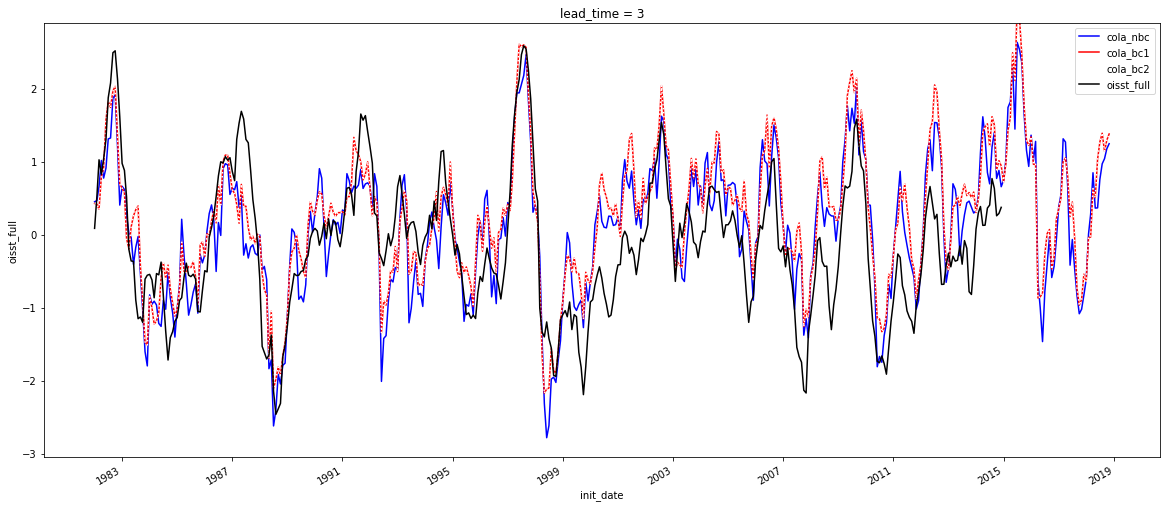

In [19]:
lead = 3
fig = plt.figure(figsize=(20,8))
cola_nino34_nbc.isel(lead_time=lead).mean('ensemble').plot(color='b')
cola_nino34_bc1.isel(lead_time=lead).mean('ensemble').plot(color='r')
cola_nino34_bc2.isel(lead_time=lead).mean('ensemble').plot(color='w', linestyle=':')
oisst_nino34_anom.isel(lead_time=lead).plot(color='k')
plt.legend();

##### So there is no defference between bc1 and bc2

### Raw GFDL-CM2p1-aer04 data

In [20]:
filelist = glob.glob('/OSM/CBR/OA_DCFP/data2/model_output/NMME/phase1/GFDL-CM2p1-aer04/monthly/sst_mon_GFDL-CM2p1-aer04_198201_r*i1p1_198201-201811.nc')
filelist.sort(key=natural_keys)

aer04_sst_raw = xr.open_mfdataset(filelist, decode_times=False)['sst'] \
                 .rename({'X' : 'lon', 'Y' : 'lat', 'M' : 'ensemble', 
                          'L' : 'lead_time', 'S' : 'init_date'}).compute() - 273.15

basedate = np.datetime64(aer04_sst_raw.init_date.units.split(' ')[2])
aer04_sst_raw['init_date'] = np.array([doppyo.sugar.month_delta(basedate, int(shift)) for shift in aer04_sst_raw.init_date.values])

aer04_sst_raw['lead_time'] = [int(lead_time - 0.5) for lead_time in aer04_sst_raw['lead_time']]
aer04_sst_raw.lead_time.attrs['units'] = 'MS'

aer04_sst_raw['ensemble'] = [int(ensemble) for ensemble in aer04_sst_raw['ensemble']]

##### Compute nino3.4

In [21]:
aer04_nino34_full_nbc = doppyo.diagnostic.nino34(aer04_sst_raw)

##### Bias correct the anomalies
Delsole "estimates the mean forecast error for each calendar month using hindcasts whose verifications lie within the period 1982–98 inclusive, and then subtracts this error from the appropriate forecast after this period"

##### nbc - anomalies computed with respect to model 1982-1998 climatology

In [22]:
clim_period = slice('1982','1998')

aer04_nino34_clim_nbc = aer04_nino34_full_nbc.sel(init_date=clim_period, lead_time=0).groupby('init_date.month').mean(['init_date','ensemble'])
aer04_nino34_nbc = aer04_nino34_full_nbc.groupby('init_date').apply(lambda_anomalize, clim=aer04_nino34_clim_nbc).rename('aer04_nbc')

##### bc1 - compute bias correction, apply to full field forecasts, anomalise full field using bias corrected climatology:

In [23]:
clim_period = slice('1982','1998')

# Compute bias correction -----
hcst = aer04_nino34_full_nbc.sel(init_date=clim_period).groupby('init_date.month').mean(['init_date','ensemble'])
ref = oisst_nino34_full.sel(init_date=clim_period).groupby('init_date.month').mean('init_date')
e = hcst - ref # e = init_date_to_target_date(hcst - ref).mean('lead_time')

# Correct full field hindcasts -----
aer04_nino34_full_bc1 = aer04_nino34_full_nbc.groupby('init_date.month') - e

# Anomalise full field using bias corrected climatology -----
aer04_nino34_clim_bc1 = aer04_nino34_full_bc1.sel(init_date=clim_period, lead_time=0).groupby('init_date.month').mean(['init_date','ensemble'])
aer04_nino34_bc1 = aer04_nino34_full_bc1.groupby('init_date').apply(lambda_anomalize, clim=aer04_nino34_clim_bc1).rename('aer04_bc1')

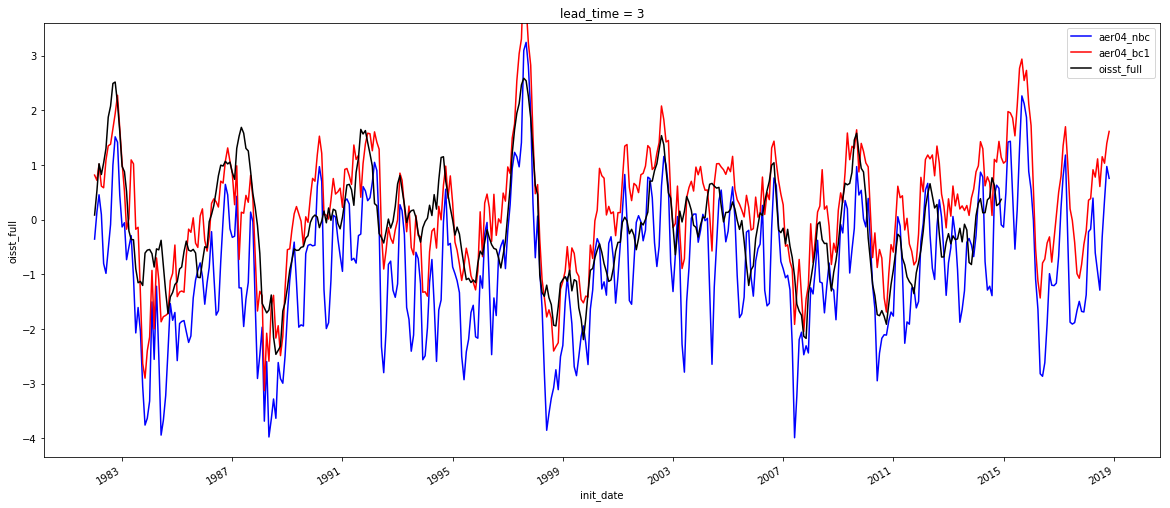

In [24]:
lead = 3
fig = plt.figure(figsize=(20,8))
aer04_nino34_nbc.isel(lead_time=lead).mean('ensemble').plot(color='b')
aer04_nino34_bc1.isel(lead_time=lead).mean('ensemble').plot(color='r')
oisst_nino34_anom.isel(lead_time=lead).plot(color='k')
plt.legend();

### Raw GFDL-CM2p5-FLOR-A06 data

In [25]:
filelist = glob.glob('/OSM/CBR/OA_DCFP/data2/model_output/NMME/phase1/GFDL-CM2p5-FLOR-A06/monthly/sst_mon_GFDL-CM2p5-FLOR-A06_198201_r*i1p1_198201-201811.nc')
filelist.sort(key=natural_keys)

florA_sst_raw = xr.open_mfdataset(filelist, decode_times=False)['sst'] \
                 .rename({'X' : 'lon', 'Y' : 'lat', 'M' : 'ensemble', 
                          'L' : 'lead_time', 'S' : 'init_date'}).compute()

basedate = np.datetime64(florA_sst_raw.init_date.units.split(' ')[2])
florA_sst_raw['init_date'] = np.array([doppyo.sugar.month_delta(basedate, int(shift)) for shift in florA_sst_raw.init_date.values])

florA_sst_raw['lead_time'] = [int(lead_time - 0.5) for lead_time in florA_sst_raw['lead_time']]
florA_sst_raw.lead_time.attrs['units'] = 'MS'

florA_sst_raw['ensemble'] = [int(ensemble) for ensemble in florA_sst_raw['ensemble']]

##### Compute nino3.4

In [26]:
florA_nino34_full_nbc = doppyo.diagnostic.nino34(florA_sst_raw)

##### Bias correct the anomalies
Delsole "estimates the mean forecast error for each calendar month using hindcasts whose verifications lie within the period 1982–98 inclusive, and then subtracts this error from the appropriate forecast after this period"

##### nbc - anomalies computed with respect to model 1982-1998 climatology

In [27]:
clim_period = slice('1982','1998')

florA_nino34_clim_nbc = florA_nino34_full_nbc.sel(init_date=clim_period, lead_time=0).groupby('init_date.month').mean(['init_date','ensemble'])
florA_nino34_nbc = florA_nino34_full_nbc.groupby('init_date').apply(lambda_anomalize, clim=florA_nino34_clim_nbc).rename('florA_nbc')

##### bc1 - compute bias correction, apply to full field forecasts, anomalise full field using bias corrected climatology:

In [28]:
clim_period = slice('1982','1998')

# Compute bias correction -----
hcst = florA_nino34_full_nbc.sel(init_date=clim_period).groupby('init_date.month').mean(['init_date','ensemble'])
ref = oisst_nino34_full.sel(init_date=clim_period).groupby('init_date.month').mean('init_date')
e = hcst - ref # e = init_date_to_target_date(hcst - ref).mean('lead_time')

# Correct full field hindcasts -----
florA_nino34_full_bc1 = florA_nino34_full_nbc.groupby('init_date.month') - e

# Anomalise full field using bias corrected climatology -----
florA_nino34_clim_bc1 = florA_nino34_full_bc1.sel(init_date=clim_period, lead_time=0).groupby('init_date.month').mean(['init_date','ensemble'])
florA_nino34_bc1 = florA_nino34_full_bc1.groupby('init_date').apply(lambda_anomalize, clim=florA_nino34_clim_bc1).rename('florA_bc1')

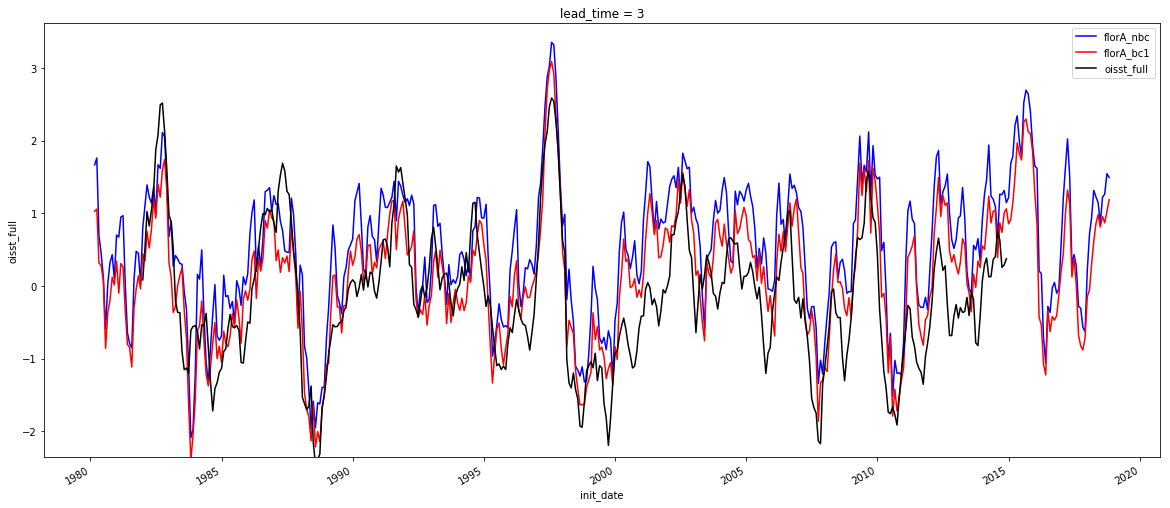

In [29]:
lead = 3
fig = plt.figure(figsize=(20,8))
florA_nino34_nbc.isel(lead_time=lead).mean('ensemble').plot(color='b')
florA_nino34_bc1.isel(lead_time=lead).mean('ensemble').plot(color='r')
oisst_nino34_anom.isel(lead_time=lead).plot(color='k')
plt.legend();

### Raw GFDL-CM2p5-FLOR-B01 data

In [30]:
filelist = glob.glob('/OSM/CBR/OA_DCFP/data2/model_output/NMME/phase1/GFDL-CM2p5-FLOR-B01/monthly/sst_mon_GFDL-CM2p5-FLOR-B01_198201_r*i1p1_198201-201811.nc')
filelist.sort(key=natural_keys)

florB_sst_raw = xr.open_mfdataset(filelist, decode_times=False)['sst'] \
                 .rename({'X' : 'lon', 'Y' : 'lat', 'M' : 'ensemble', 
                          'L' : 'lead_time', 'S' : 'init_date'}).compute()

basedate = np.datetime64(florB_sst_raw.init_date.units.split(' ')[2])
florB_sst_raw['init_date'] = np.array([doppyo.sugar.month_delta(basedate, int(shift)) for shift in florB_sst_raw.init_date.values])

florB_sst_raw['lead_time'] = [int(lead_time - 0.5) for lead_time in florB_sst_raw['lead_time']]
florB_sst_raw.lead_time.attrs['units'] = 'MS'

florB_sst_raw['ensemble'] = [int(ensemble) for ensemble in florB_sst_raw['ensemble']]

##### Compute nino3.4

In [31]:
florB_nino34_full_nbc = doppyo.diagnostic.nino34(florB_sst_raw)

##### Bias correct the anomalies
Delsole "estimates the mean forecast error for each calendar month using hindcasts whose verifications lie within the period 1982–98 inclusive, and then subtracts this error from the appropriate forecast after this period"

##### nbc - anomalies computed with respect to model 1982-1998 climatology

In [32]:
clim_period = slice('1982','1998')

florB_nino34_clim_nbc = florB_nino34_full_nbc.sel(init_date=clim_period, lead_time=0).groupby('init_date.month').mean(['init_date','ensemble'])
florB_nino34_nbc = florB_nino34_full_nbc.groupby('init_date').apply(lambda_anomalize, clim=florB_nino34_clim_nbc).rename('florB_nbc')

##### bc1 - compute bias correction, apply to full field forecasts, anomalise full field using bias corrected climatology:

In [33]:
clim_period = slice('1982','1998')

# Compute bias correction -----
hcst = florB_nino34_full_nbc.sel(init_date=clim_period).groupby('init_date.month').mean(['init_date','ensemble'])
ref = oisst_nino34_full.sel(init_date=clim_period).groupby('init_date.month').mean('init_date')
e = hcst - ref # e = init_date_to_target_date(hcst - ref).mean('lead_time')

# Correct full field hindcasts -----
florB_nino34_full_bc1 = florB_nino34_full_nbc.groupby('init_date.month') - e

# Anomalise full field using bias corrected climatology -----
florB_nino34_clim_bc1 = florB_nino34_full_bc1.sel(init_date=clim_period, lead_time=0).groupby('init_date.month').mean(['init_date','ensemble'])
florB_nino34_bc1 = florB_nino34_full_bc1.groupby('init_date').apply(lambda_anomalize, clim=florB_nino34_clim_bc1).rename('florB_bc1')

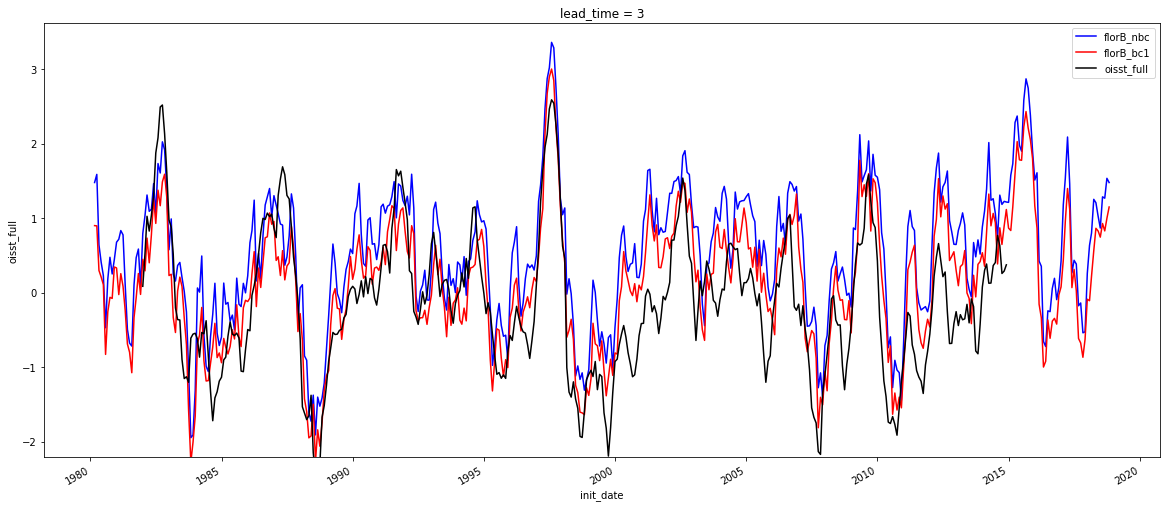

In [34]:
lead = 3
fig = plt.figure(figsize=(20,8))
florB_nino34_nbc.isel(lead_time=lead).mean('ensemble').plot(color='b')
florB_nino34_bc1.isel(lead_time=lead).mean('ensemble').plot(color='r')
oisst_nino34_anom.isel(lead_time=lead).plot(color='k')
plt.legend();

### Raw CMC CanCM3 data

In [35]:
folder = '/OSM/CBR/OA_DCFP/data2/model_output/NMME/phase1/CMC_CanCM3/monthly/'
hcstfiles = 'sst_mon_CanCM3_198101*.nc'
fcstfiles = 'sst_mon_CanCM3_201101*.nc'

hcstlist = glob.glob(folder + hcstfiles)
hcstlist.sort(key=natural_keys)
fcstlist = glob.glob(folder + fcstfiles)
fcstlist.sort(key=natural_keys)

cm3_sst_raw = xr.concat([xr.open_mfdataset(hcstlist, decode_times=False)['sst'] - 273.15,
                         xr.open_mfdataset(fcstlist, decode_times=False)['sst'] - 273.15], dim='S') \
                .rename({'X' : 'lon', 'Y' : 'lat', 'M' : 'ensemble', 
                         'L' : 'lead_time', 'S' : 'init_date'}).compute()

basedate = np.datetime64(cm3_sst_raw.init_date.units.split(' ')[2])
cm3_sst_raw['init_date'] = np.array([doppyo.sugar.month_delta(basedate, int(shift)) for shift in cm3_sst_raw.init_date.values])

cm3_sst_raw['lead_time'] = [int(lead_time - 0.5) for lead_time in cm3_sst_raw['lead_time']]
cm3_sst_raw.lead_time.attrs['units'] = 'MS'

cm3_sst_raw['ensemble'] = [int(ensemble) for ensemble in cm3_sst_raw['ensemble']]

##### Compute nino3.4

In [36]:
cm3_nino34_full_nbc = doppyo.diagnostic.nino34(cm3_sst_raw)

##### Bias correct the anomalies
Delsole "estimates the mean forecast error for each calendar month using hindcasts whose verifications lie within the period 1982–98 inclusive, and then subtracts this error from the appropriate forecast after this period"

##### nbc - anomalies computed with respect to model 1982-1998 climatology

In [37]:
clim_period = slice('1982','1998')

cm3_nino34_clim_nbc = cm3_nino34_full_nbc.sel(init_date=clim_period, lead_time=0).groupby('init_date.month').mean(['init_date','ensemble'])
cm3_nino34_nbc = cm3_nino34_full_nbc.groupby('init_date').apply(lambda_anomalize, clim=cm3_nino34_clim_nbc).rename('cm3_nbc')

##### bc1 - compute bias correction, apply to full field forecasts, anomalise full field using bias corrected climatology:

In [38]:
clim_period = slice('1982','1998')

# Compute bias correction -----
hcst = cm3_nino34_full_nbc.sel(init_date=clim_period).groupby('init_date.month').mean(['init_date','ensemble'])
ref = oisst_nino34_full.sel(init_date=clim_period).groupby('init_date.month').mean('init_date')
e = hcst - ref # e = init_date_to_target_date(hcst - ref).mean('lead_time')

# Correct full field hindcasts -----
cm3_nino34_full_bc1 = cm3_nino34_full_nbc.groupby('init_date.month') - e

# Anomalise full field using bias corrected climatology -----
cm3_nino34_clim_bc1 = cm3_nino34_full_bc1.sel(init_date=clim_period, lead_time=0).groupby('init_date.month').mean(['init_date','ensemble'])
cm3_nino34_bc1 = cm3_nino34_full_bc1.groupby('init_date').apply(lambda_anomalize, clim=cm3_nino34_clim_bc1).rename('cm3_bc1')

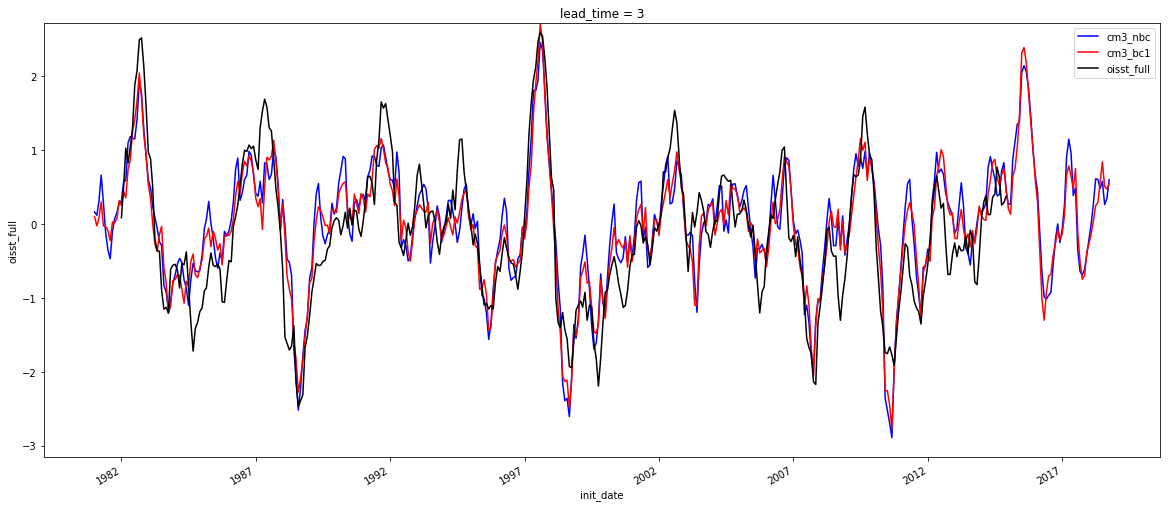

In [39]:
lead = 3
fig = plt.figure(figsize=(20,8))
cm3_nino34_nbc.isel(lead_time=lead).mean('ensemble').plot(color='b')
cm3_nino34_bc1.isel(lead_time=lead).mean('ensemble').plot(color='r')
oisst_nino34_anom.isel(lead_time=lead).plot(color='k')
plt.legend();

### Raw CMC CanCM4 data

In [40]:
folder = '/OSM/CBR/OA_DCFP/data2/model_output/NMME/phase1/CMC_CanCM4/monthly/'
hcstfiles = 'sst_mon_CanCM4_198101*.nc'
fcstfiles = 'sst_mon_CanCM4_201101*.nc'

hcstlist = glob.glob(folder + hcstfiles)
hcstlist.sort(key=natural_keys)
fcstlist = glob.glob(folder + fcstfiles)
fcstlist.sort(key=natural_keys)

cm4_sst_raw = xr.concat([xr.open_mfdataset(hcstlist, decode_times=False)['sst'] - 273.15,
                         xr.open_mfdataset(fcstlist, decode_times=False)['sst'] - 273.15], dim='S') \
                .rename({'X' : 'lon', 'Y' : 'lat', 'M' : 'ensemble', 
                         'L' : 'lead_time', 'S' : 'init_date'}).compute()

basedate = np.datetime64(cm4_sst_raw.init_date.units.split(' ')[2])
cm4_sst_raw['init_date'] = np.array([doppyo.sugar.month_delta(basedate, int(shift)) for shift in cm4_sst_raw.init_date.values])

cm4_sst_raw['lead_time'] = [int(lead_time - 0.5) for lead_time in cm4_sst_raw['lead_time']]
cm4_sst_raw.lead_time.attrs['units'] = 'MS'

cm4_sst_raw['ensemble'] = [int(ensemble) for ensemble in cm4_sst_raw['ensemble']]

##### Compute nino3.4

In [41]:
cm4_nino34_full_nbc = doppyo.diagnostic.nino34(cm4_sst_raw)

##### Bias correct the anomalies
Delsole "estimates the mean forecast error for each calendar month using hindcasts whose verifications lie within the period 1982–98 inclusive, and then subtracts this error from the appropriate forecast after this period"

##### nbc - anomalies computed with respect to model 1982-1998 climatology

In [42]:
clim_period = slice('1982','1998') 

cm4_nino34_clim_nbc = cm4_nino34_full_nbc.sel(init_date=clim_period, lead_time=0).groupby('init_date.month').mean(['init_date','ensemble'])
cm4_nino34_nbc = cm4_nino34_full_nbc.groupby('init_date').apply(lambda_anomalize, clim=cm4_nino34_clim_nbc).rename('cm4_nbc')

##### bc1 - compute bias correction, apply to full field forecasts, anomalise full field using bias corrected climatology:

In [43]:
clim_period = slice('1982','1998')

# Compute bias correction -----
hcst = cm4_nino34_full_nbc.sel(init_date=clim_period).groupby('init_date.month').mean(['init_date','ensemble'])
ref = oisst_nino34_full.sel(init_date=clim_period).groupby('init_date.month').mean('init_date')
e = hcst - ref # e = init_date_to_target_date(hcst - ref).mean('lead_time')

# Correct full field hindcasts -----
cm4_nino34_full_bc1 = cm4_nino34_full_nbc.groupby('init_date.month') - e

# Anomalise full field using bias corrected climatology -----
cm4_nino34_clim_bc1 = cm4_nino34_full_bc1.sel(init_date=clim_period, lead_time=0).groupby('init_date.month').mean(['init_date','ensemble'])
cm4_nino34_bc1 = cm4_nino34_full_bc1.groupby('init_date').apply(lambda_anomalize, clim=cm4_nino34_clim_bc1).rename('cm4_bc1')

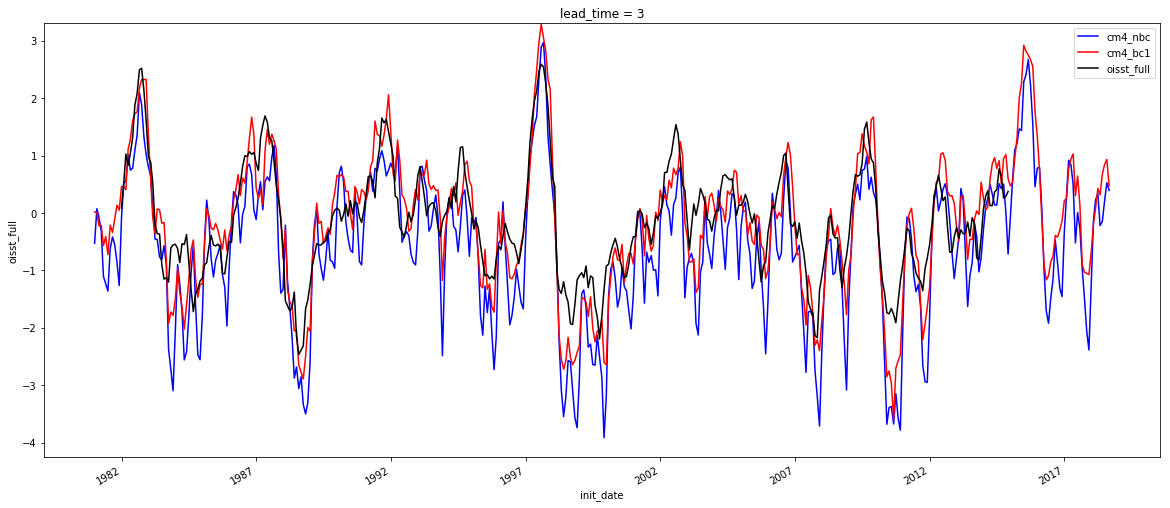

In [44]:
lead = 3
fig = plt.figure(figsize=(20,8))
cm4_nino34_nbc.isel(lead_time=lead).mean('ensemble').plot(color='b')
cm4_nino34_bc1.isel(lead_time=lead).mean('ensemble').plot(color='r')
oisst_nino34_anom.isel(lead_time=lead).plot(color='k')
plt.legend();

# Ordinary linear regression model

In [45]:
def Delsole_regression_fit(da):
    return doppyo.utils.polyfit(da.sel(lead_time=0), da.sel(lead_time=range(1,12)), order=1, over_dims='init_date')

In [46]:
def Delsole_regression_predict(da, p):
    month = da.init_date.dt.month.values[0]
    return doppyo.utils.polyval(da, p.sel(month=month, drop=True), over_dims='init_date')

In [47]:
clim_period = slice('1982','1998')

p = oisst_nino34_anom.sel(init_date=clim_period).groupby('init_date.month').apply(Delsole_regression_fit)

In [48]:
test_period = slice('1999','2014')

regr_nino34 = oisst_nino34_anom.sel(init_date=test_period) \
                               .sel(lead_time=0, drop=True) \
                               .groupby('init_date.month', squeeze=True) \
                               .apply(Delsole_regression_predict, p=p).drop('month')

# Non-bias-corrected models relative to each other

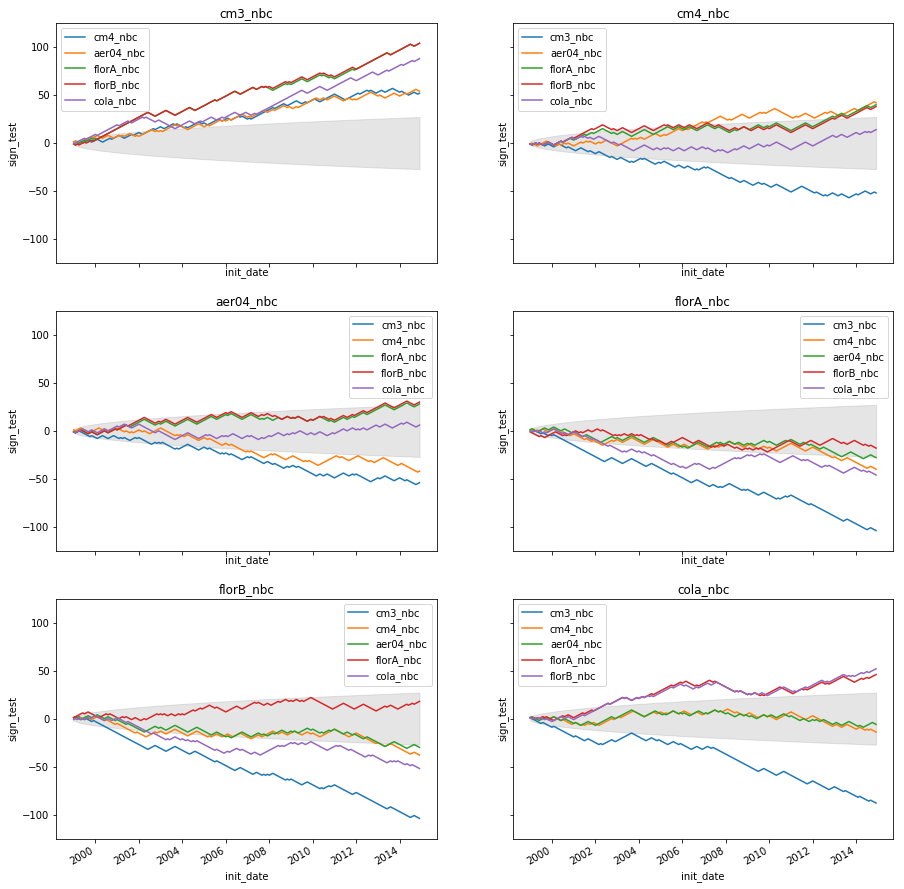

In [57]:
fig = plt.figure(figsize=(15,15))
lead = 2
ax = fig.subplots(nrows=3, ncols=2, sharex=True, sharey=True).flatten()
models = [cm3_nino34_nbc, cm4_nino34_nbc, aer04_nino34_nbc, florA_nino34_nbc, florB_nino34_nbc, cola_nino34_nbc]

for idx, model_a in enumerate(models):
    for idy , model_b in enumerate([models[i] for i in list(set(range(len(models))) - set([idx]))]):
        walk, confidence = doppyo.skill.sign_test(model_a.mean('ensemble'), model_b.mean('ensemble'), oisst_nino34_anom.sel(init_date=test_period), scaled=False)
        if idy == 0:
            ax[idx].fill_between(confidence.init_date.values,
                         (-1 * confidence), confidence, color='gray', alpha=0.2, label='_nolegend_')
        walk.sel(lead_time=lead).plot(ax=ax[idx], label=model_b.name)
        if idy == (len(models)-2):
            ax[idx].set_title(model_a.name)
        ax[idx].set_ylim(-125,125)
            
    ax[idx].legend();
plt.subplots_adjust()

# Bias-corrected models relative to each other

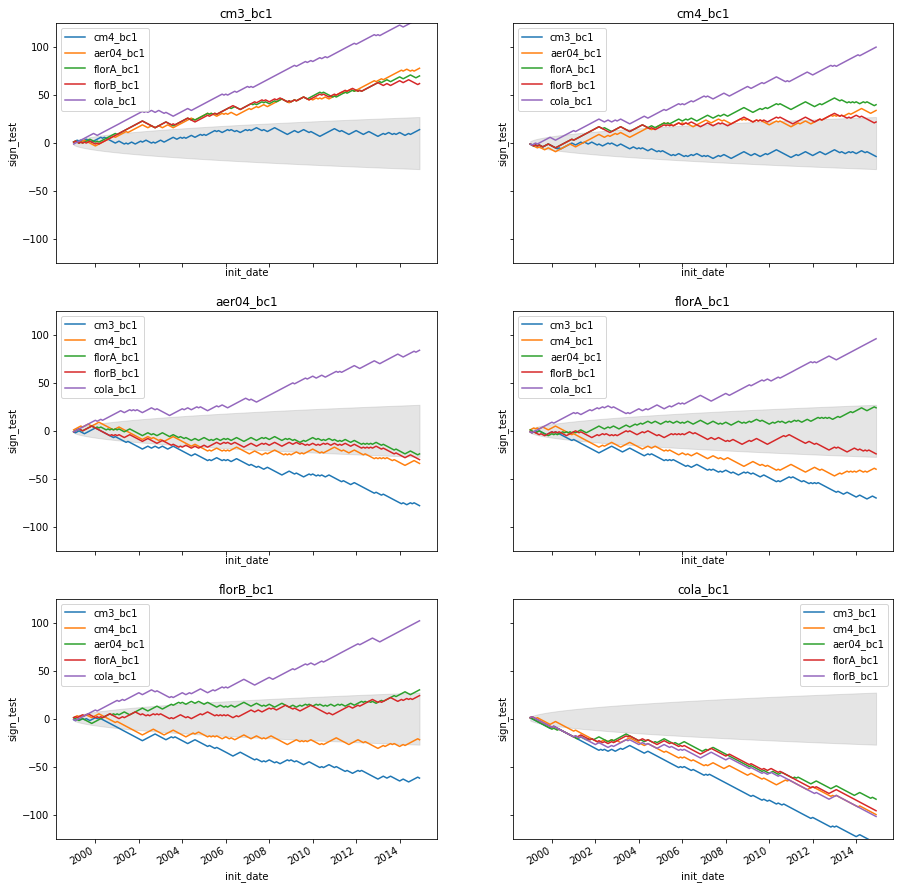

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://172.19.0.4:44589 remote=tcp://oa-32-cdc.nexus.csiro.au:8786>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://172.19.0.4:45237 remote=tcp://oa-32-cdc.nexus.csiro.au:8786>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://172.19.0.4:45215 remote=tcp://oa-32-cdc.nexus.csiro.au:8786>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://172.19.0.4:45227 remote=tcp://oa-32-cdc.nexus.csiro.au:8786>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://172.19.0.4:45188 remote=tcp://oa-32-cdc.nexus.csiro.au:8786>


In [58]:
fig = plt.figure(figsize=(15,15))
lead = 2
ax = fig.subplots(nrows=3, ncols=2, sharex=True, sharey=True).flatten()
models = [cm3_nino34_bc1, cm4_nino34_bc1, aer04_nino34_bc1, florA_nino34_bc1, florB_nino34_bc1, cola_nino34_bc1]

for idx, model_a in enumerate(models):
    for idy , model_b in enumerate([models[i] for i in list(set(range(len(models))) - set([idx]))]):
        walk, confidence = doppyo.skill.sign_test(model_a.mean('ensemble'), model_b.mean('ensemble'), oisst_nino34_anom.sel(init_date=test_period), scaled=False)
        if idy == 0:
            ax[idx].fill_between(confidence.init_date.values,
                         (-1 * confidence), confidence, color='gray', alpha=0.2, label='_nolegend_')
        walk.sel(lead_time=lead).plot(ax=ax[idx], label=model_b.name)
        if idy == (len(models)-2):
            ax[idx].set_title(model_a.name)
        ax[idx].set_ylim(-125,125)
            
    ax[idx].legend();
plt.subplots_adjust()

# Relative to regression model (not-bias-corrected)

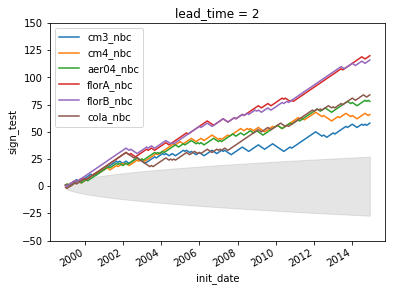

In [56]:
lead = 2
for idx, model in enumerate([cm3_nino34_nbc, cm4_nino34_nbc, aer04_nino34_nbc, florA_nino34_nbc, florB_nino34_nbc, cola_nino34_nbc]):
    walk, confidence = doppyo.skill.sign_test(regr_nino34, model.mean('ensemble'), oisst_nino34_anom.sel(init_date=test_period), scaled=False)
    if idx == 0:
        plt.fill_between(confidence.init_date.values,
                     (-1 * confidence), confidence, color='gray', alpha=0.2, label='_nolegend_')
    
    walk.sel(lead_time=lead).plot(label=model.name)
plt.ylim(-50,150)
plt.legend();

# Relative to regression model (bias corrected)

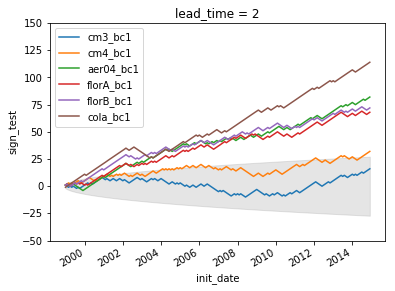

In [54]:
lead = 2
for idx, model in enumerate([cm3_nino34_bc1, cm4_nino34_bc1, aer04_nino34_bc1, florA_nino34_bc1, florB_nino34_bc1, cola_nino34_bc1]):
    walk, confidence = doppyo.skill.sign_test(regr_nino34, model.mean('ensemble'), oisst_nino34_anom.sel(init_date=test_period), scaled=False)
    if idx == 0:
        plt.fill_between(confidence.init_date.values,
                     (-1 * confidence), confidence, color='gray', alpha=0.2, label='_nolegend_')
    
    walk.sel(lead_time=lead).plot(label=model.name)
plt.ylim(-50,150)
plt.legend();